# Unit05_DBSCAN | 副標題：基於密度的分群演算法應用於反應器異常操作檢測

本 Notebook 使用 `Part_2/data/reactor_operation/` 中的模擬反應器操作數據，建立 DBSCAN 分群模型來識別正常與異常操作模式。

## 目標
- 理解 DBSCAN 演算法的實作步驟
- 學習如何選擇最佳參數 (eps 和 min_samples)
- 掌握 DBSCAN 的評估方法與視覺化技巧
- 應用 DBSCAN 於化工製程異常檢測

資料背景可參考：Unit05_DBSCAN.md 講義

---
## 0. 環境設定

In [15]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit05_DBSCAN'
SOURCE_DATA_DIR = 'reactor_operation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit05'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\data\reactor_operation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_DBSCAN
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit05\outputs\P2_Unit05_DBSCAN\figs


In [16]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 模擬數據生成

我們模擬一個連續攪拌槽式反應器 (CSTR) 的操作數據，包含三種操作模式：
1. **正常操作模式 1**：高產率操作條件 (溫度較高，壓力適中)
2. **正常操作模式 2**：低產率操作條件 (溫度較低，壓力較低)
3. **異常操作**：設備故障或原料問題導致的異常狀態 (噪音點)

特徵包括：反應溫度、反應壓力、進料流速、攪拌速度、產物純度、轉化率

In [17]:
# 設定隨機種子
np.random.seed(SEED)

# 模擬操作模式 1：高產率操作 (200個樣本)
n_mode1 = 200
temp_mode1 = np.random.normal(85, 3, n_mode1)      # 溫度 (°C)
pressure_mode1 = np.random.normal(5.0, 0.3, n_mode1)  # 壓力 (bar)
flow_mode1 = np.random.normal(100, 5, n_mode1)    # 流速 (m³/h)
stirring_mode1 = np.random.normal(300, 15, n_mode1)  # 攪拌速度 (rpm)
purity_mode1 = np.random.normal(95, 2, n_mode1)    # 純度 (%)
conversion_mode1 = np.random.normal(88, 3, n_mode1)  # 轉化率 (%)

# 模擬操作模式 2：低產率操作 (150個樣本)
n_mode2 = 150
temp_mode2 = np.random.normal(70, 3, n_mode2)
pressure_mode2 = np.random.normal(3.5, 0.3, n_mode2)
flow_mode2 = np.random.normal(80, 5, n_mode2)
stirring_mode2 = np.random.normal(250, 15, n_mode2)
purity_mode2 = np.random.normal(85, 2, n_mode2)
conversion_mode2 = np.random.normal(75, 3, n_mode2)

# 模擬異常操作 (50個噪音點)
n_anomaly = 50
temp_anomaly = np.random.uniform(60, 95, n_anomaly)
pressure_anomaly = np.random.uniform(2.0, 6.5, n_anomaly)
flow_anomaly = np.random.uniform(60, 120, n_anomaly)
stirring_anomaly = np.random.uniform(200, 350, n_anomaly)
purity_anomaly = np.random.uniform(70, 98, n_anomaly)
conversion_anomaly = np.random.uniform(60, 90, n_anomaly)

# 合併所有數據
X = np.column_stack([
    np.concatenate([temp_mode1, temp_mode2, temp_anomaly]),
    np.concatenate([pressure_mode1, pressure_mode2, pressure_anomaly]),
    np.concatenate([flow_mode1, flow_mode2, flow_anomaly]),
    np.concatenate([stirring_mode1, stirring_mode2, stirring_anomaly]),
    np.concatenate([purity_mode1, purity_mode2, purity_anomaly]),
    np.concatenate([conversion_mode1, conversion_mode2, conversion_anomaly])
])

# 創建真實標籤 (用於後續驗證)
true_labels = np.concatenate([
    np.zeros(n_mode1, dtype=int),      # 模式 1
    np.ones(n_mode2, dtype=int),       # 模式 2
    np.full(n_anomaly, -1, dtype=int)  # 異常
])

# 創建 DataFrame
feature_names = ['Temperature', 'Pressure', 'Flow_Rate', 'Stirring_Speed', 'Purity', 'Conversion']
df = pd.DataFrame(X, columns=feature_names)
df['True_Label'] = true_labels

print(f"數據集大小: {df.shape}")
print(f"\n數據統計:")
print(df.describe())
print(f"\n真實標籤分布:")
print(df['True_Label'].value_counts().sort_index())

數據集大小: (400, 7)

數據統計:
       Temperature    Pressure   Flow_Rate  Stirring_Speed      Purity  \
count   400.000000  400.000000  400.000000      400.000000  400.000000   
mean     78.059750    4.381070   91.501287      277.892650   89.925420   
std       8.217725    0.889400   12.081797       31.115930    6.364415   
min      60.047377    2.035287   62.633997      201.355770   70.000326   
25%      70.260723    3.592543   80.439206      252.806225   84.784242   
50%      80.778768    4.698718   94.128047      280.612202   92.121211   
75%      85.307408    5.092460  100.584149      302.588615   95.375463   
max      94.160484    6.460976  119.689158      348.988252  100.053865   

       Conversion  True_Label  
count  400.000000  400.000000  
mean    81.978672    0.250000  
std      7.604778    0.662266  
min     61.272669   -1.000000  
25%     75.446707    0.000000  
50%     83.643361    0.000000  
75%     88.615548    1.000000  
max     95.319257    1.000000  

真實標籤分布:
True_Label
-1

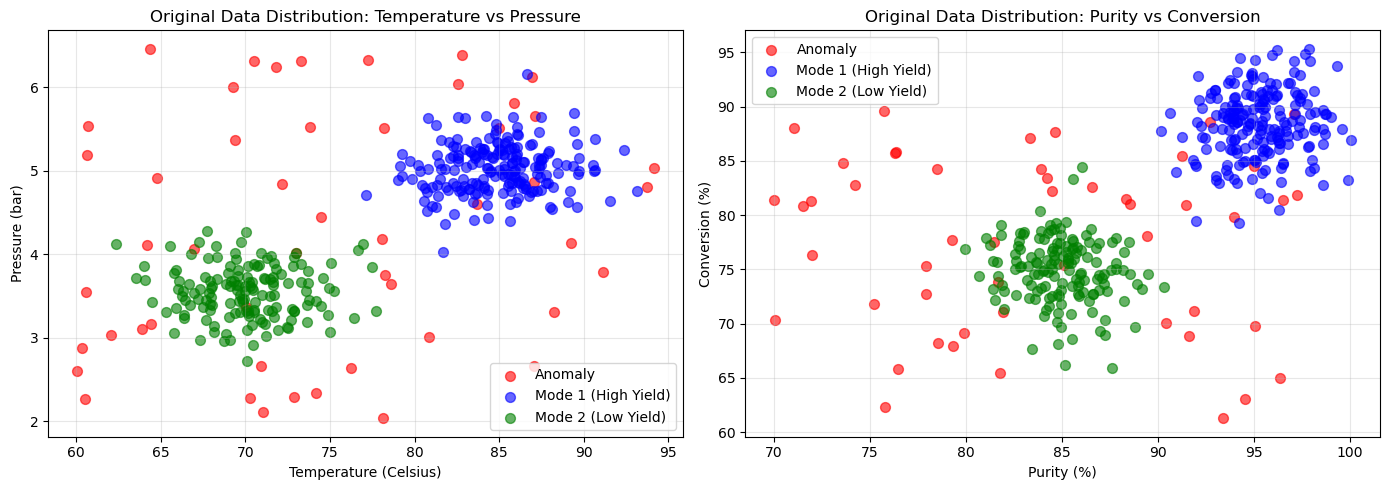

✓ 原始數據視覺化完成


In [18]:
# 視覺化原始數據分布 (使用前兩個特徵)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：溫度 vs 壓力
colors = ['blue', 'green', 'red']
labels_text = ['Mode 1 (High Yield)', 'Mode 2 (Low Yield)', 'Anomaly']
for i in range(-1, 2):
    mask = df['True_Label'] == i
    axes[0].scatter(df.loc[mask, 'Temperature'], df.loc[mask, 'Pressure'], 
                   c=colors[i], label=labels_text[i], alpha=0.6, s=50)
axes[0].set_xlabel('Temperature (Celsius)')
axes[0].set_ylabel('Pressure (bar)')
axes[0].set_title('Original Data Distribution: Temperature vs Pressure')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右圖：純度 vs 轉化率
for i in range(-1, 2):
    mask = df['True_Label'] == i
    axes[1].scatter(df.loc[mask, 'Purity'], df.loc[mask, 'Conversion'], 
                   c=colors[i], label=labels_text[i], alpha=0.6, s=50)
axes[1].set_xlabel('Purity (%)')
axes[1].set_ylabel('Conversion (%)')
axes[1].set_title('Original Data Distribution: Purity vs Conversion')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'original_data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 原始數據視覺化完成")

---
## 2. 數據標準化

DBSCAN 基於距離計算，因此數據標準化是必要的步驟。

In [19]:
# 提取特徵矩陣
X = df[feature_names].values

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 創建標準化後的 DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)

print("標準化前後對比:")
print("\n標準化前 (前5行):")
print(df[feature_names].head())
print("\n標準化後 (前5行):")
print(df_scaled.head())
print(f"\n標準化後的統計量 (均值應接近0，標準差應接近1):")
print(df_scaled.describe().loc[['mean', 'std']])

標準化前後對比:

標準化前 (前5行):
   Temperature  Pressure   Flow_Rate  Stirring_Speed     Purity  Conversion
0    86.490142  5.107336   92.027862      311.354829  96.876568   92.198066
1    84.585207  5.168235   97.003125      286.167520  93.967911   90.773901
2    86.943066  5.324915  100.026218      313.044089  95.192242   88.178891
3    89.569090  5.316141  100.234903      320.334568  94.075449   86.059190
4    84.297540  4.586699   97.749673      306.201524  94.131008   90.094670

標準化後 (前5行):
   Temperature  Pressure  Flow_Rate  Stirring_Speed    Purity  Conversion
0     1.027164  0.817603   0.043639        1.076750  1.093557    1.345495
1     0.795065  0.886161   0.455953        0.266270  0.635966    1.157988
2     1.082348  1.062545   0.706485        1.131107  0.828578    0.816327
3     1.402305  1.052667   0.723779        1.365701  0.652884    0.537245
4     0.760016  0.231490   0.517821        0.910927  0.661625    1.068560

標準化後的統計量 (均值應接近0，標準差應接近1):
       Temperature      Pressure     

---
## 3. 參數選擇：K-距離圖法

使用 K-距離圖來確定最佳的 eps 參數。

**方法說明：**
1. 計算每個點到第 k 個最近鄰的距離 (k = min_samples)
2. 將所有距離排序並繪製
3. 尋找曲線的「肘部」(elbow point) - 斜率急劇變化的位置
4. 肘部對應的距離值即為建議的 eps 值

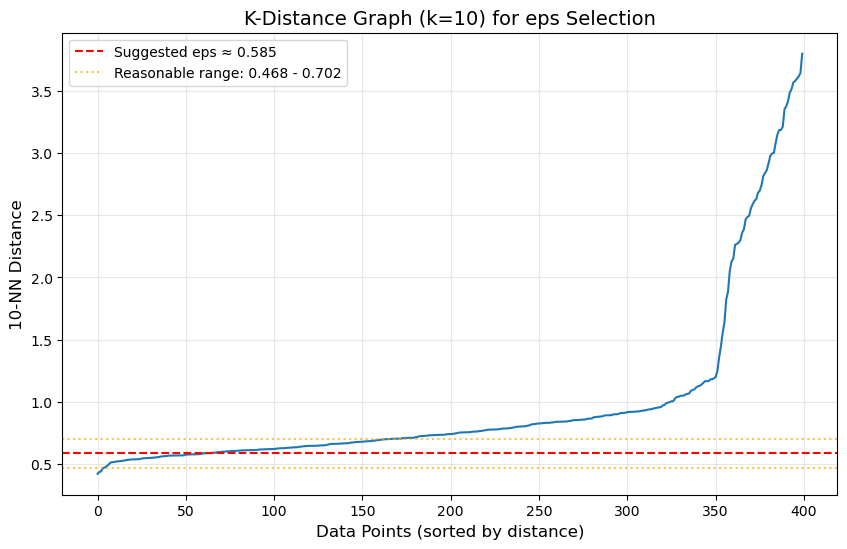

根據 K-距離圖分析:
  - 建議的 eps 值: 0.585
  - 合理範圍: 0.468 - 0.702
  - 我們將使用 eps = 0.80 進行訓練

提示：如果噪音點比例過高 (>30%)，應增加 eps 值
      如果群集過度合併，應減小 eps 值


In [20]:
# 設定 min_samples 參數
# 對於 6 維數據，建議值為 2*d = 12，我們使用 10
min_samples = 10

# 計算每個點到第 k 個最近鄰的距離
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# 排序 k-距離
k_distances = np.sort(distances[:, min_samples-1], axis=0)

# 繪製 K-距離圖
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.ylabel(f'{min_samples}-NN Distance', fontsize=12)
plt.xlabel('Data Points (sorted by distance)', fontsize=12)
plt.title(f'K-Distance Graph (k={min_samples}) for eps Selection', fontsize=14)
plt.grid(True, alpha=0.3)

# 尋找肘部位置 - 使用二階導數方法
# 計算二階導數來找到曲線急劇變化的位置
second_derivative = np.gradient(np.gradient(k_distances))
# 找到二階導數絕對值最大的點（曲率最大）
elbow_idx = np.argmax(np.abs(second_derivative[50:150])) + 50  # 在中間區域尋找
suggested_eps = k_distances[elbow_idx]

# 標示建議的 eps 範圍
plt.axhline(y=suggested_eps, color='r', linestyle='--', 
            label=f'Suggested eps ≈ {suggested_eps:.3f}')
# 標示合理範圍
plt.axhline(y=suggested_eps*0.8, color='orange', linestyle=':', alpha=0.7,
            label=f'Reasonable range: {suggested_eps*0.8:.3f} - {suggested_eps*1.2:.3f}')
plt.axhline(y=suggested_eps*1.2, color='orange', linestyle=':', alpha=0.7)
plt.legend()
plt.savefig(FIG_DIR / 'k_distance_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"根據 K-距離圖分析:")
print(f"  - 建議的 eps 值: {suggested_eps:.3f}")
print(f"  - 合理範圍: {suggested_eps*0.8:.3f} - {suggested_eps*1.2:.3f}")
print(f"  - 我們將使用 eps = {max(0.8, suggested_eps):.2f} 進行訓練")
print(f"\n提示：如果噪音點比例過高 (>30%)，應增加 eps 值")
print(f"      如果群集過度合併，應減小 eps 值")

---
## 4. DBSCAN 模型訓練

建立並訓練 DBSCAN 模型。

**參數設定策略：**
- `eps`: 根據 K-距離圖建議值，並考慮數據特性進行微調
- `min_samples`: 設為 10 (約為特徵維度 6 的 1.5-2 倍)
- 目標：噪音點比例控制在 5%-30% 的合理範圍內

In [21]:
# 建立 DBSCAN 模型
# 使用較大的 eps 值以降低噪音點比例
eps = 0.9  # 根據標準化後的數據調整
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)

# 訓練模型 (執行分群)
labels = dbscan.fit_predict(X_scaled)

# 結果統計
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
n_total = len(labels)

print("=" * 60)
print("DBSCAN 分群結果")
print("=" * 60)
print(f"參數設定:")
print(f"  - eps: {eps}")
print(f"  - min_samples: {min_samples}")
print(f"\n分群結果:")
print(f"  - 發現的群集數量: {n_clusters}")
print(f"  - 噪音點數量: {n_noise}")
print(f"  - 噪音點比例: {n_noise / n_total * 100:.2f}%")
print(f"  - 核心點數量: {len(dbscan.core_sample_indices_)}")

# 評估噪音點比例是否合理
if n_noise / n_total > 0.3:
    print(f"\n⚠️  警告：噪音點比例過高 (>{30}%)")
    print(f"    建議：增加 eps 值 (當前: {eps})")
elif n_noise / n_total < 0.05:
    print(f"\n⚠️  警告：噪音點比例過低 (<{5}%)")
    print(f"    建議：減小 eps 值或增加 min_samples (當前 eps: {eps})")
else:
    print(f"\n✓  噪音點比例合理 (5%-30%)")

print(f"\n各群集的樣本數:")
for i in range(n_clusters):
    n_samples_in_cluster = np.sum(labels == i)
    percentage = n_samples_in_cluster / n_total * 100
    print(f"  - 群集 {i}: {n_samples_in_cluster:3d} 個樣本 ({percentage:5.1f}%)")
print("=" * 60)

DBSCAN 分群結果
參數設定:
  - eps: 0.9
  - min_samples: 10

分群結果:
  - 發現的群集數量: 2
  - 噪音點數量: 52
  - 噪音點比例: 13.00%
  - 核心點數量: 295

✓  噪音點比例合理 (5%-30%)

各群集的樣本數:
  - 群集 0: 200 個樣本 ( 50.0%)
  - 群集 1: 148 個樣本 ( 37.0%)


---
## 5. 模型評估

評估 DBSCAN 的分群品質。

In [22]:
# 排除噪音點進行評估
mask = labels != -1
X_without_noise = X_scaled[mask]
labels_without_noise = labels[mask]

print("=" * 60)
print("模型評估指標 (排除噪音點)")
print("=" * 60)

if len(set(labels_without_noise)) > 1:
    # 輪廓係數 (Silhouette Score)
    silhouette = silhouette_score(X_without_noise, labels_without_noise)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"  - 範圍: [-1, 1]，越接近 1 表示分群效果越好")
    print(f"  - 解讀: ", end="")
    if silhouette > 0.7:
        print("優秀 (>0.7)")
    elif silhouette > 0.5:
        print("良好 (0.5-0.7)")
    elif silhouette > 0.25:
        print("普通 (0.25-0.5)")
    else:
        print("較差 (<0.25)")
    
    # Davies-Bouldin 指數
    db_index = davies_bouldin_score(X_without_noise, labels_without_noise)
    print(f"\nDavies-Bouldin Index: {db_index:.4f}")
    print(f"  - 範圍: [0, ∞)，越小表示分群效果越好")
    print(f"  - 解讀: ", end="")
    if db_index < 0.5:
        print("優秀 (<0.5)")
    elif db_index < 1.0:
        print("良好 (0.5-1.0)")
    else:
        print("普通 (>1.0)")
    
    # Calinski-Harabasz 指數
    ch_index = calinski_harabasz_score(X_without_noise, labels_without_noise)
    print(f"\nCalinski-Harabasz Index: {ch_index:.4f}")
    print(f"  - 範圍: [0, ∞)，越大表示分群效果越好")
    print(f"  - 解讀: 值越大表示群集定義越清晰")
else:
    print("只有一個群集，無法計算評估指標")

print("=" * 60)

模型評估指標 (排除噪音點)
Silhouette Score: 0.7021
  - 範圍: [-1, 1]，越接近 1 表示分群效果越好
  - 解讀: 優秀 (>0.7)

Davies-Bouldin Index: 0.4343
  - 範圍: [0, ∞)，越小表示分群效果越好
  - 解讀: 優秀 (<0.5)

Calinski-Harabasz Index: 1633.5408
  - 範圍: [0, ∞)，越大表示分群效果越好
  - 解讀: 值越大表示群集定義越清晰


---
## 6. 結果視覺化

使用多種方法視覺化 DBSCAN 的分群結果。

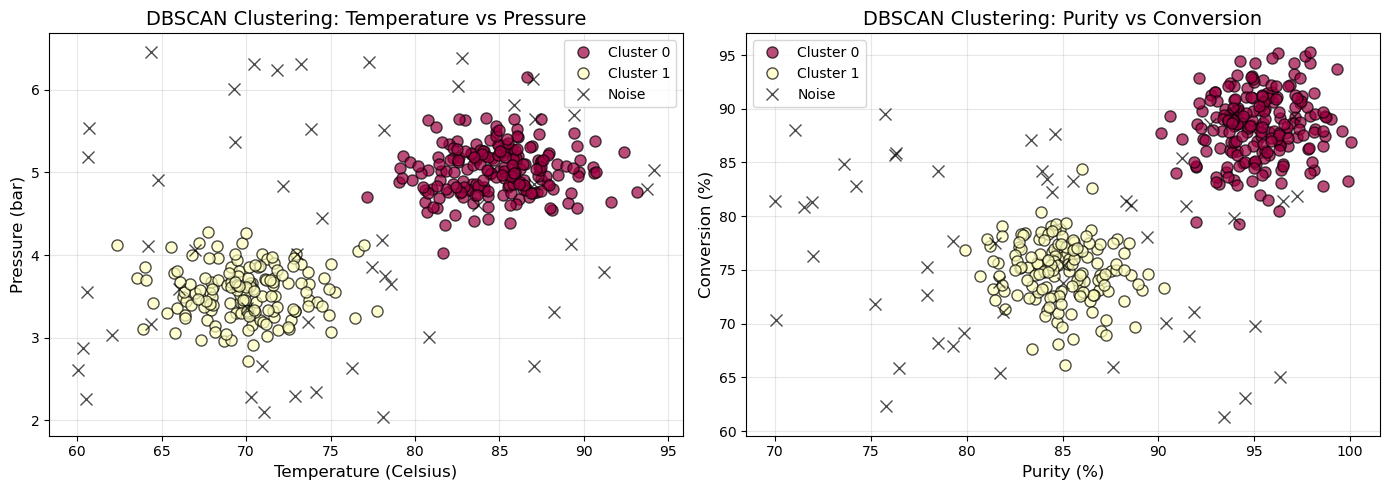

✓ DBSCAN 分群結果視覺化完成


In [23]:
# 視覺化 DBSCAN 分群結果 (原始特徵空間)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 定義顏色
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# 左圖：溫度 vs 壓力
for k, col in zip(unique_labels, colors):
    if k == -1:
        # 噪音點用黑色 X 標記
        col = [0, 0, 0, 1]
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = df.loc[class_member_mask, ['Temperature', 'Pressure']].values
    axes[0].plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=8, alpha=0.7, label=label)

axes[0].set_xlabel('Temperature (Celsius)', fontsize=12)
axes[0].set_ylabel('Pressure (bar)', fontsize=12)
axes[0].set_title('DBSCAN Clustering: Temperature vs Pressure', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右圖：純度 vs 轉化率
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
        marker = 'x'
        label = 'Noise'
    else:
        marker = 'o'
        label = f'Cluster {k}'
    
    class_member_mask = (labels == k)
    xy = df.loc[class_member_mask, ['Purity', 'Conversion']].values
    axes[1].plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=8, alpha=0.7, label=label)

axes[1].set_xlabel('Purity (%)', fontsize=12)
axes[1].set_ylabel('Conversion (%)', fontsize=12)
axes[1].set_title('DBSCAN Clustering: Purity vs Conversion', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'dbscan_clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ DBSCAN 分群結果視覺化完成")

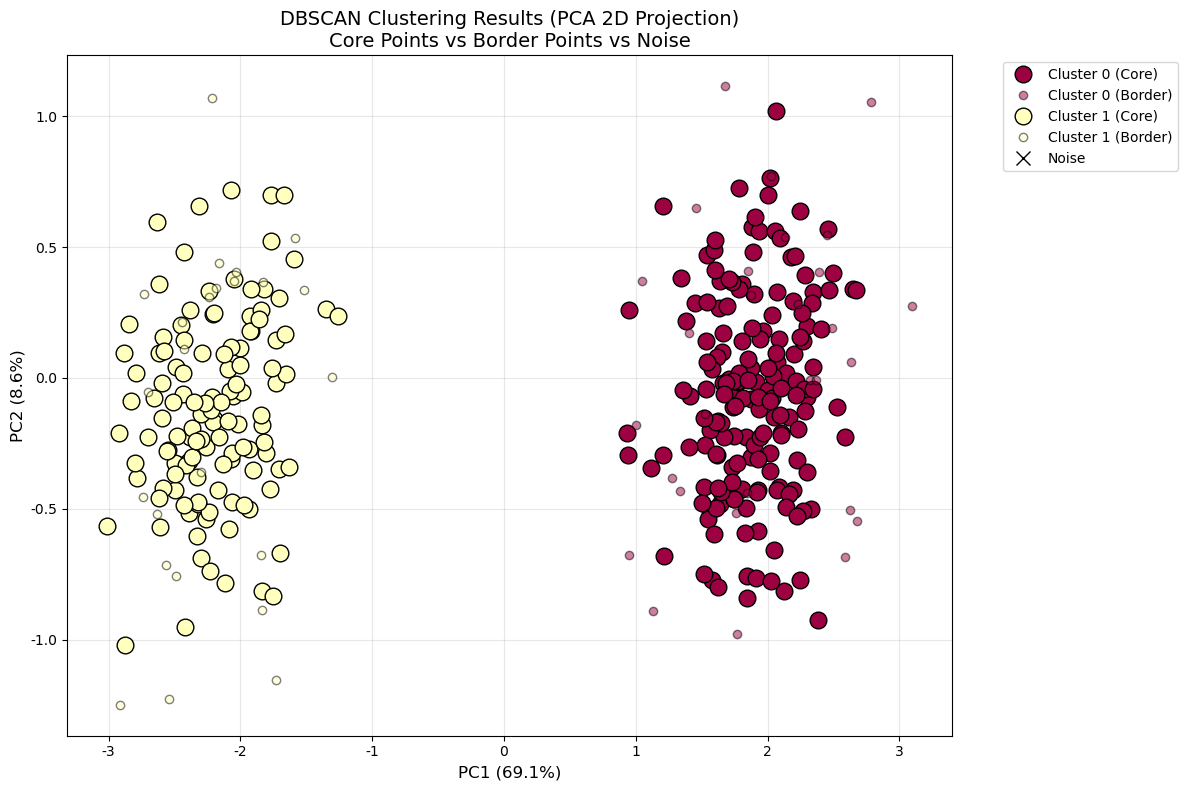

✓ PCA 降維視覺化完成
  - PC1 解釋變異數: 69.15%
  - PC2 解釋變異數: 8.55%
  - 累積解釋變異數: 77.70%


In [24]:
# 使用 PCA 降維視覺化 (6維 -> 2維)
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# 建立核心點遮罩
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

fig, ax = plt.subplots(figsize=(12, 8))

# 繪製所有點
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 噪音點
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels == k)
    
    # 核心點 (較大的點)
    xy = X_pca[class_member_mask & core_samples_mask]
    if k == -1:
        ax.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=10, label='Noise')
    else:
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=12, label=f'Cluster {k} (Core)')
    
    # 邊界點 (較小的點)
    xy = X_pca[class_member_mask & ~core_samples_mask]
    if k != -1:
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=6, alpha=0.5, 
               label=f'Cluster {k} (Border)')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('DBSCAN Clustering Results (PCA 2D Projection)\nCore Points vs Border Points vs Noise', 
            fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'dbscan_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PCA 降維視覺化完成")
print(f"  - PC1 解釋變異數: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  - PC2 解釋變異數: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  - 累積解釋變異數: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

---
## 7. 群集特徵分析

分析每個群集的特徵統計，理解不同操作模式的特性。

In [25]:
# 分析每個群集的特徵統計
print("=" * 80)
print("群集特徵分析")
print("=" * 80)

for i in range(n_clusters):
    cluster_data = df[labels == i]
    print(f"\n{'='*40}")
    print(f"群集 {i} 分析")
    print(f"{'='*40}")
    print(f"樣本數: {len(cluster_data)}")
    print(f"\n平均值:")
    for col in feature_names:
        mean_val = cluster_data[col].mean()
        print(f"  - {col:20s}: {mean_val:8.2f}")
    
    print(f"\n標準差:")
    for col in feature_names:
        std_val = cluster_data[col].std()
        print(f"  - {col:20s}: {std_val:8.2f}")

# 分析噪音點
if n_noise > 0:
    noise_data = df[labels == -1]
    print(f"\n{'='*40}")
    print(f"噪音點 (異常操作) 分析")
    print(f"{'='*40}")
    print(f"樣本數: {len(noise_data)}")
    print(f"\n平均值:")
    for col in feature_names:
        mean_val = noise_data[col].mean()
        print(f"  - {col:20s}: {mean_val:8.2f}")
    
    print(f"\n與正常操作的差異:")
    normal_data = df[labels != -1]
    for col in feature_names:
        noise_mean = noise_data[col].mean()
        normal_mean = normal_data[col].mean()
        diff = noise_mean - normal_mean
        print(f"  - {col:20s}: {diff:+8.2f}")

print("=" * 80)

群集特徵分析

群集 0 分析
樣本數: 200

平均值:
  - Temperature         :    84.86
  - Pressure            :     5.02
  - Flow_Rate           :    99.56
  - Stirring_Speed      :   300.17
  - Purity              :    95.26
  - Conversion          :    88.38

標準差:
  - Temperature         :     2.77
  - Pressure            :     0.29
  - Flow_Rate           :     4.95
  - Stirring_Speed      :    15.27
  - Purity              :     1.91
  - Conversion          :     3.10

群集 1 分析
樣本數: 148

平均值:
  - Temperature         :    69.96
  - Pressure            :     3.55
  - Flow_Rate           :    80.16
  - Stirring_Speed      :   251.51
  - Purity              :    84.95
  - Conversion          :    74.98

標準差:
  - Temperature         :     2.85
  - Pressure            :     0.31
  - Flow_Rate           :     5.14
  - Stirring_Speed      :    13.74
  - Purity              :     1.96
  - Conversion          :     2.87

噪音點 (異常操作) 分析
樣本數: 52

平均值:
  - Temperature         :    74.97
  - Pressure            :    

---
## 8. 與真實標籤比較

比較 DBSCAN 的結果與真實標籤 (僅用於教學驗證)。

In [26]:
# 創建交叉對照表
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score

print("=" * 60)
print("DBSCAN 結果與真實標籤的比較")
print("=" * 60)

# 混淆矩陣
cm = confusion_matrix(true_labels, labels)
print("\n混淆矩陣:")
print("行: 真實標籤, 列: DBSCAN 標籤")
print(cm)

# 計算準確率統計
print("\n分類準確性分析:")
for true_label in [-1, 0, 1]:
    mask = true_labels == true_label
    predicted = labels[mask]
    
    if true_label == -1:
        label_name = "異常操作"
        # 計算被正確識別為噪音的比例
        correct = np.sum(predicted == -1)
    elif true_label == 0:
        label_name = "模式 1 (高產率)"
        # 計算被分到同一群集的比例
        correct = np.sum(predicted == 0)  # 假設模式1對應群集0
    else:
        label_name = "模式 2 (低產率)"
        correct = np.sum(predicted == 1)  # 假設模式2對應群集1
    
    total = np.sum(mask)
    accuracy = correct / total * 100
    print(f"  {label_name:20s}: {correct:3d}/{total:3d} ({accuracy:5.1f}%)")

# 外部評估指標
ari = adjusted_rand_score(true_labels, labels)
nmi = normalized_mutual_info_score(true_labels, labels)

print(f"\n外部評估指標:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"    - 範圍: [-1, 1]，1表示完全匹配")
print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"    - 範圍: [0, 1]，1表示完全匹配")

print("=" * 60)

DBSCAN 結果與真實標籤的比較

混淆矩陣:
行: 真實標籤, 列: DBSCAN 標籤
[[ 48   1   1]
 [  1 199   0]
 [  3   0 147]]

分類準確性分析:
  異常操作                :  48/ 50 ( 96.0%)
  模式 1 (高產率)          : 199/200 ( 99.5%)
  模式 2 (低產率)          : 147/150 ( 98.0%)

外部評估指標:
  Adjusted Rand Index (ARI): 0.9667
    - 範圍: [-1, 1]，1表示完全匹配
  Normalized Mutual Information (NMI): 0.9240
    - 範圍: [0, 1]，1表示完全匹配


---
## 9. 參數敏感性分析

測試不同的 eps 和 min_samples 參數對分群結果的影響。

參數敏感性分析結果:
 eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette
 0.3            5           0      400       100.00         NaN
 0.3           10           0      400       100.00         NaN
 0.3           15           0      400       100.00         NaN
 0.3           20           0      400       100.00         NaN
 0.4            5           1      380        95.00         NaN
 0.4           10           0      400       100.00         NaN
 0.4           15           0      400       100.00         NaN
 0.4           20           0      400       100.00         NaN
 0.5            5           3      271        67.75    0.346235
 0.5           10           2      364        91.00    0.389601
 0.5           15           1      384        96.00         NaN
 0.5           20           0      400       100.00         NaN
 0.6            5           2      155        38.75    0.747045
 0.6           10           2      206        51.50    0.766366
 0.6           15           2

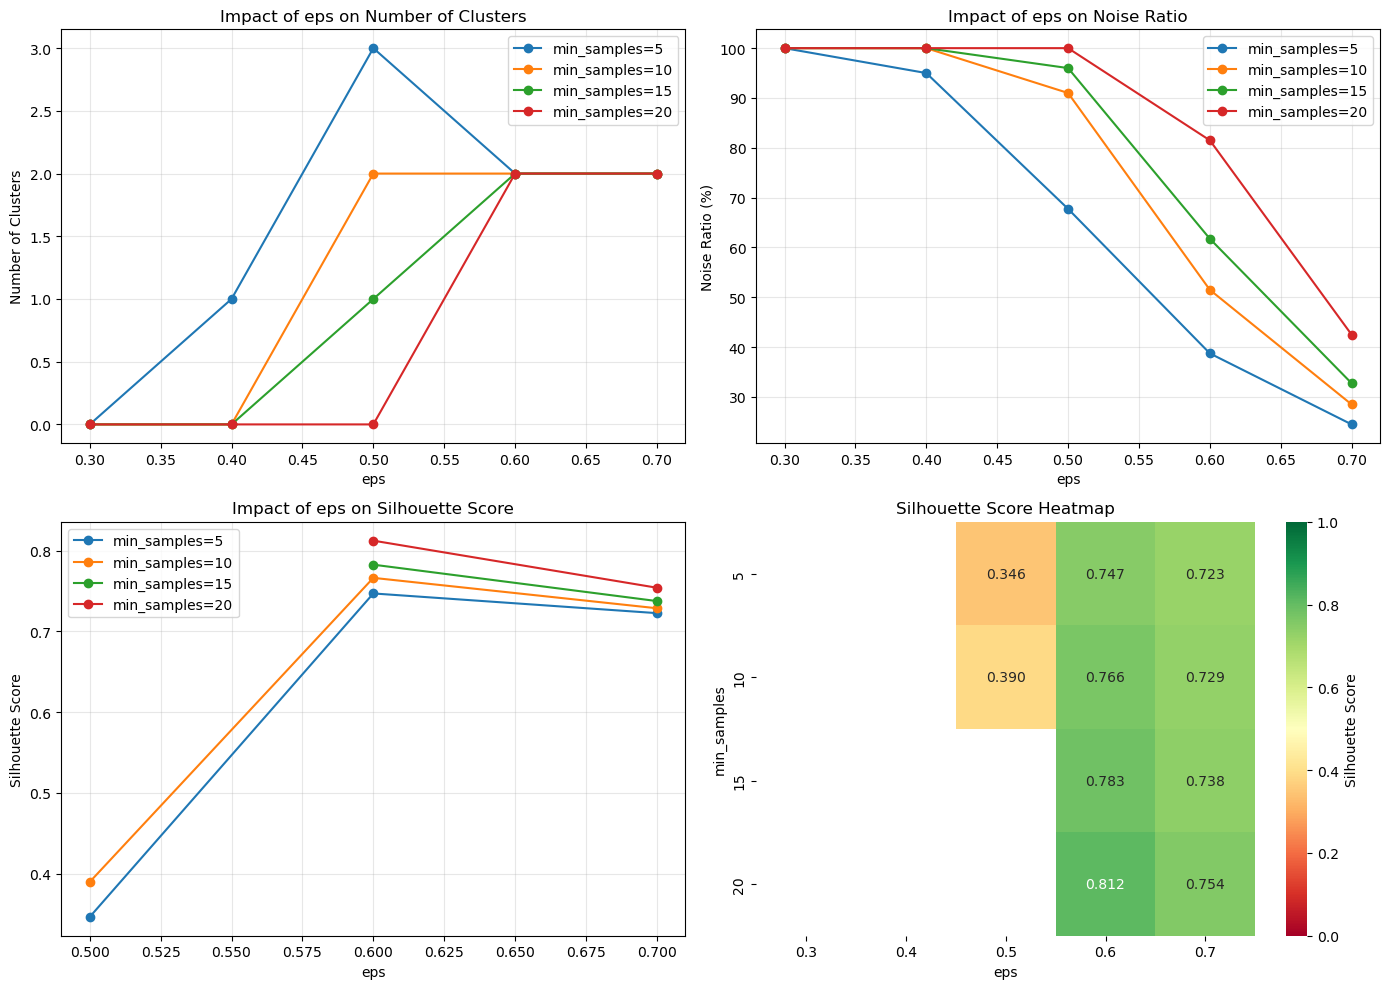


✓ 參數敏感性分析完成


In [27]:
# 測試不同的參數組合
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [5, 10, 15, 20]

results = []

for eps_test in eps_values:
    for min_samples_test in min_samples_values:
        dbscan_test = DBSCAN(eps=eps_test, min_samples=min_samples_test, n_jobs=-1)
        labels_test = dbscan_test.fit_predict(X_scaled)
        
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        noise_ratio_test = n_noise_test / len(labels_test) * 100
        
        # 計算評估指標 (如果有多個群集)
        mask_test = labels_test != -1
        if len(set(labels_test[mask_test])) > 1:
            silhouette_test = silhouette_score(X_scaled[mask_test], labels_test[mask_test])
        else:
            silhouette_test = np.nan
        
        results.append({
            'eps': eps_test,
            'min_samples': min_samples_test,
            'n_clusters': n_clusters_test,
            'n_noise': n_noise_test,
            'noise_ratio': noise_ratio_test,
            'silhouette': silhouette_test
        })

# 創建結果 DataFrame
results_df = pd.DataFrame(results)

print("參數敏感性分析結果:")
print(results_df.to_string(index=False))

# 視覺化參數影響
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 群集數量 vs eps (不同 min_samples)
for ms in min_samples_values:
    data = results_df[results_df['min_samples'] == ms]
    axes[0, 0].plot(data['eps'], data['n_clusters'], 'o-', label=f'min_samples={ms}')
axes[0, 0].set_xlabel('eps')
axes[0, 0].set_ylabel('Number of Clusters')
axes[0, 0].set_title('Impact of eps on Number of Clusters')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 噪音點比例 vs eps
for ms in min_samples_values:
    data = results_df[results_df['min_samples'] == ms]
    axes[0, 1].plot(data['eps'], data['noise_ratio'], 'o-', label=f'min_samples={ms}')
axes[0, 1].set_xlabel('eps')
axes[0, 1].set_ylabel('Noise Ratio (%)')
axes[0, 1].set_title('Impact of eps on Noise Ratio')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Silhouette Score vs eps
for ms in min_samples_values:
    data = results_df[results_df['min_samples'] == ms]
    axes[1, 0].plot(data['eps'], data['silhouette'], 'o-', label=f'min_samples={ms}')
axes[1, 0].set_xlabel('eps')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Impact of eps on Silhouette Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 熱圖：Silhouette Score
pivot_table = results_df.pivot(index='min_samples', columns='eps', values='silhouette')
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1, 1], 
            vmin=0, vmax=1, cbar_kws={'label': 'Silhouette Score'})
axes[1, 1].set_title('Silhouette Score Heatmap')
axes[1, 1].set_xlabel('eps')
axes[1, 1].set_ylabel('min_samples')

plt.tight_layout()
plt.savefig(FIG_DIR / 'parameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 參數敏感性分析完成")

---
## 10. 總結與建議

本 Notebook 展示了 DBSCAN 在化工製程異常檢測中的應用。

In [28]:
print("=" * 80)
print("DBSCAN 分群分析總結")
print("=" * 80)

print("\n✓ 完成的工作:")
print("  1. 生成反應器操作數據 (包含正常模式與異常操作)")
print("  2. 數據標準化處理")
print("  3. 使用 K-距離圖選擇 eps 參數")
print("  4. 訓練 DBSCAN 模型")
print("  5. 評估分群品質 (Silhouette Score, DB Index, CH Index)")
print("  6. 視覺化分群結果 (原始特徵空間與 PCA 降維)")
print("  7. 分析各群集的特徵統計")
print("  8. 比較 DBSCAN 結果與真實標籤")
print("  9. 參數敏感性分析")

print("\n✓ 關鍵發現:")
print(f"  - DBSCAN 發現了 {n_clusters} 個主要的操作模式")
print(f"  - 成功識別了 {n_noise} 個異常操作點 ({n_noise / n_total * 100:.1f}%)")
if 'silhouette' in locals():
    print(f"  - 分群品質: Silhouette Score = {silhouette:.3f}")
    if silhouette > 0.5:
        print(f"    (評價: 良好)")
    elif silhouette > 0.25:
        print(f"    (評價: 普通，可透過參數調整改善)")
    else:
        print(f"    (評價: 較差，建議重新調整參數)")

print("\n✓ DBSCAN 的優勢:")
print("  - 自動發現群集數量，無需預先指定")
print("  - 能夠識別任意形狀的群集")
print("  - 有效識別噪音點 (異常操作)")
print("  - 對異常值具有魯棒性")

print("\n✓ 實務應用建議:")
print("  1. 數據標準化是必須的步驟")
print("  2. 使用 K-距離圖輔助 eps 參數選擇")
print("  3. min_samples 建議設為 1.5-2 倍的特徵維度")
print("  4. 噪音點比例應控制在 5%-30% 之間")
print("  5. 結合領域知識驗證分群結果")
print("  6. 定期更新模型以適應製程變化")
print("  7. 將異常點作為預警信號，及時介入")

print("\n✓ 參數調整指南:")
print("  - 噪音點過多 (>30%)  → 增加 eps 或減小 min_samples")
print("  - 噪音點過少 (<5%)   → 減小 eps 或增加 min_samples")
print("  - 群集過度合併       → 減小 eps")
print("  - 群集過度分割       → 增加 eps")

print("\n✓ 進階學習方向:")
print("  - 探索 HDBSCAN (處理不同密度的群集)")
print("  - 結合時間序列分析 (考慮操作的時間順序)")
print("  - 多尺度分析 (不同時間窗口的分群)")
print("  - 線上監控應用 (實時異常檢測)")

print("\n" + "=" * 80)
print("✓ DBSCAN 分群分析完成！")
print("=" * 80)

DBSCAN 分群分析總結

✓ 完成的工作:
  1. 生成反應器操作數據 (包含正常模式與異常操作)
  2. 數據標準化處理
  3. 使用 K-距離圖選擇 eps 參數
  4. 訓練 DBSCAN 模型
  5. 評估分群品質 (Silhouette Score, DB Index, CH Index)
  6. 視覺化分群結果 (原始特徵空間與 PCA 降維)
  7. 分析各群集的特徵統計
  8. 比較 DBSCAN 結果與真實標籤
  9. 參數敏感性分析

✓ 關鍵發現:
  - DBSCAN 發現了 2 個主要的操作模式
  - 成功識別了 52 個異常操作點 (13.0%)
  - 分群品質: Silhouette Score = 0.702
    (評價: 良好)

✓ DBSCAN 的優勢:
  - 自動發現群集數量，無需預先指定
  - 能夠識別任意形狀的群集
  - 有效識別噪音點 (異常操作)
  - 對異常值具有魯棒性

✓ 實務應用建議:
  1. 數據標準化是必須的步驟
  2. 使用 K-距離圖輔助 eps 參數選擇
  3. min_samples 建議設為 1.5-2 倍的特徵維度
  4. 噪音點比例應控制在 5%-30% 之間
  5. 結合領域知識驗證分群結果
  6. 定期更新模型以適應製程變化
  7. 將異常點作為預警信號，及時介入

✓ 參數調整指南:
  - 噪音點過多 (>30%)  → 增加 eps 或減小 min_samples
  - 噪音點過少 (<5%)   → 減小 eps 或增加 min_samples
  - 群集過度合併       → 減小 eps
  - 群集過度分割       → 增加 eps

✓ 進階學習方向:
  - 探索 HDBSCAN (處理不同密度的群集)
  - 結合時間序列分析 (考慮操作的時間順序)
  - 多尺度分析 (不同時間窗口的分群)
  - 線上監控應用 (實時異常檢測)

✓ DBSCAN 分群分析完成！
